In [ ]:
# Preliminary data generation
import scipy as sp
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.sparse
import scipy.sparse.linalg
import theano as T
import theano.tensor as tt
import pymc3 as pm
import seaborn as sbn
np.set_printoptions(precision=3, suppress=True)
# there are some FutureWarnings from theano.Tensor
import warnings
warnings.filterwarnings('ignore')

np.random.seed(314159)

Bayesian Factor Analysis not only incorporates available knowledge regarding the model parameters in the form of prior distribution but allows the knowledge in these and subsequent data to accumulate in the determination of parameter values.

In non-bayesian Factor Analysis, the factor loading matrix is determinate up to an orthogonal rotation. Typically after a non-bayesian Factor Analysis, an orthogonal rotation is performed on the factor loading matrix according to one of many subjective criteria. 

In Bayesian Factor Analysis, the rotation is automatically found. There is an entire probability distribution for the factor loading matrix and we determine its value statistically.

The model for factor analysis is the probabilistic matrix factorization

$X_{(d,n)}|W_{(d,k)}, F_{(k,n)} \sim N(WF, \Psi)$

with $\Psi$ a diagonal matrix. Subscripts denote the dimensionality of the matrices. 

- Probabilistic PCA is a variant that sets $\Psi = \sigma^2I$.
- FA is variant that sets $\Psi = diag(\varphi_1, \varphi_2,...,\varphi_n)$

In [11]:
def expand_packed_block_triangular(n, k, packed, diag=None, mtype='theano'):
    # like expand_packed_triangular, but with n > k.
    assert mtype in {'theano', 'numpy'}
    assert n >= k
    def set_(M, i_, v_):
        if mtype == 'theano':
            return tt.set_subtensor(M[i_], v_)
        M[i_] = v_
        return M
    out = tt.zeros((n, k), dtype=float) if mtype == 'theano' else np.zeros((n,k), dtype=float)
    if diag is None:
        idxs = np.tril_indices(n, m=k)
        out = set_(out, idxs, packed)
    else:
        idxs = np.tril_indices(n, k=-1, m=k)
        out = set_(out, idxs, packed)
        idxs = (np.arange(k), np.arange(k))
        out = set_(out, idxs, diag)
    return out


def makeW(dat, k):
    # make a W matrix adapted to the data shape
    n_od = int(k*d - k*(k-1)/2 - k)
    z = pm.HalfNormal('W_z', 1., shape=(k,))  # trick: the cumulative sum of z will be positive increasing
    b = pm.Normal('W_b', 0., 1., shape=(n_od,))
    ones = tt.ones(k)
    L = pm.Deterministic('W_L', expand_packed_block_triangular(d, k, b, ones))
    W = pm.Deterministic('W', tt.dot(L, tt.diag(tt.extra_ops.cumsum(z))))
    return W

In [16]:
# Define all constants
n = 250
k_true = 5
d = 9
err_sd = 2
n_samples = 350

# Create dummy datasets of certain distribution
M = np.random.binomial(1, 0.25, size=(k_true, n))
Q = np.hstack([np.random.exponential(2*k_true - k, size=(d, 1)) for k in range(k_true)]) * np.random.binomial(1, 0.75, size=(d, k_true))
Y = np.round(1000 * np.dot(Q, M) + np.random.normal(size=(d, n)) * err_sd)/1000

Only 350 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 8,967.4:  23%|██▎       | 45375/200000 [00:35<02:04, 1243.08it/s]  
Convergence achieved at 45400
Interrupted at 45,399 [22%]: Average Loss = 73,800
Sequential sampling (4 chains in 1 job)
NUTS: [psi, F, W_b, W_z]
100%|██████████| 850/850 [00:06<00:00, 126.18it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


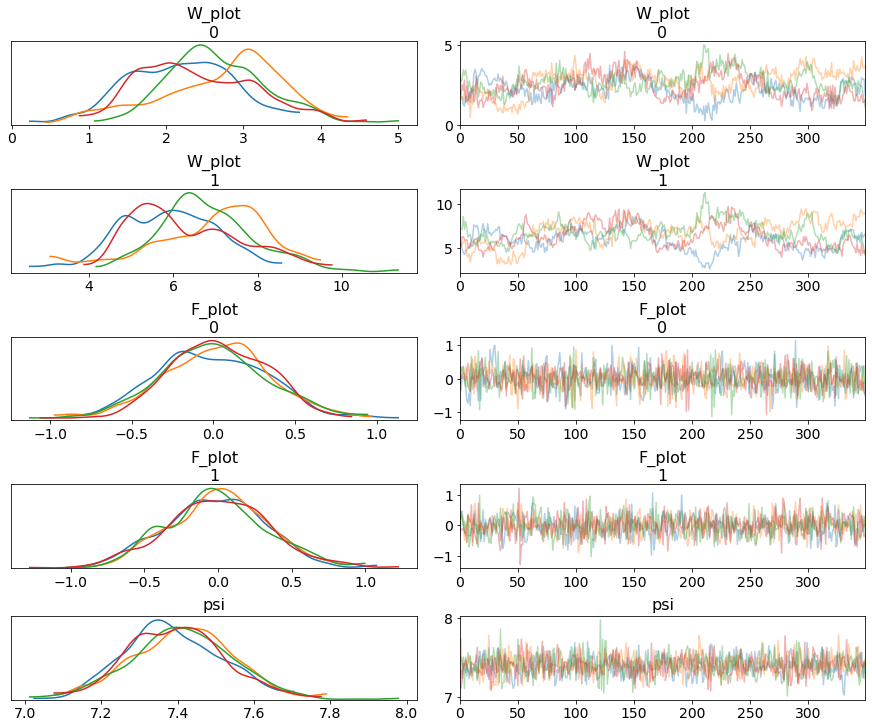

In [17]:
# Running model
k = 2
# start sampling
with pm.Model() as FA:
    # 
    W = makeW(Y, k)
    F = pm.Normal('F', shape=(k,n))
    psi = pm.HalfNormal('psi', 1.)
    X = pm.Normal('X', mu=tt.dot(W, F), sd=psi, observed=Y)
    # select a subset of weights and factors to plot
    W_plot = pm.Deterministic('W_plot', W[1:3,0])
    F_plot = pm.Deterministic('F_plot', F[0,1:3])
    # sampling distribution
    trace = pm.sample(n_samples, chains=4, cores=1, init='advi+adapt_diag')
# plot trace
pm.traceplot(trace, ('W_plot', 'F_plot', 'psi'));